# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Anne Mari Suenaga Sakai
**RA**: 822304

**Nome**: Felipe Jun Nishitani
**RA**: 822353


---
## Imports e configuração inicial

Carregamos os módulos necessários, incluindo os scripts do projeto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.preprocessamento import *
from scripts.analise_exploratoria import *
from scripts.experimentos import *
from scripts.analise_resultados import *

---
### Análise exploratória

Nesta seção, deve ser feita a leitura da base de dados e todas as análises necessárias para interpretar e analisar os dados, tais como:
* Significado de cada atributo
* Medidas descritivas
* Gráficos

A base contém atributos derivados de sensores vestíveis, representando médias, desvios padrão, máximos e mínimos das medições fisiológicas de cada usuário.  
A variável **classe** indica o tipo de esforço (Stress, Aeróbico ou Anaeróbico).

- Os boxplots revelam a presença de outliers em alguns atributos, sugerindo variações extremas entre sujeitos.  
- A matriz de correlação mostra que certos sensores apresentam relações lineares, indicando possíveis atributos redundantes.  
- As distribuições das classes mostram um conjunto relativamente balanceado entre as categorias.


In [2]:
base_path = "dataset"
df = carregar_e_resumir(base_path)


--- Carregando dataset ---

✅ Primeiras linhas do dataset:


,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,4068.866638,0.820908,63.758315,1.934911,0.020494,2.189811,-0.001937,0.514308,2.191749,98.821344,12.900442,0.045673,0.064240,34.270396,0.000272,0.650409
1,U_56491,ANAEROBIC,4208.309169,0.682113,64.493546,6.992256,0.021553,0.695010,-0.001748,0.666640,0.696758,88.201980,19.964373,0.120337,0.207697,28.349428,-0.000181,0.684502
2,U_94628,ANAEROBIC,4142.529156,0.599849,64.116317,5.623789,0.009702,4.049409,-0.001584,3.069452,4.050993,105.932371,19.995435,0.065383,0.105671,33.942008,0.000139,0.573410
3,U_97819,AEROBIC,4220.643865,0.540780,64.888648,3.179186,0.029392,5.359092,-0.001485,5.371593,5.360577,84.796326,11.185594,0.097257,0.114572,30.956354,0.000148,0.788914
4,U_96956,STRESS,4188.899763,0.666053,64.686163,2.144774,0.001560,0.670497,-0.001202,0.493036,0.671699,79.560809,6.384096,0.056268,0.073907,31.656112,-0.000073,0.434737



📊 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               75 non-null     object 
 1   classe           75 non-null     object 
 2   acc_energy       75 non-null     float64
 3   acc_entropy      75 non-null     float64
 4   acc_mag_mean     75 non-null     float64
 5   acc_mag_std      75 non-null     float64
 6   bvp_mean         75 non-null     float64
 7   eda_mean         75 non-null     float64
 8   eda_phasic_mean  75 non-null     float64
 9   eda_std          75 non-null     float64
 10  eda_tonic_mean   75 non-null     float64
 11  hr_mean          75 non-null     float64
 12  hr_std           75 non-null     float64
 13  hrv_rmssd        73 non-null     float64
 14  hrv_sdnn         73 non-null     float64
 15  temp_mean        75 non-null     float64
 16  temp_slope       75 non-null     float64


,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
count,75,75,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,73.000000,73.000000,75.000000,75.000000,75.000000
unique,75,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,U_16259,ANAEROBIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4300.559844,0.838452,64.888560,3.955418,0.003332,6.680819,-0.002192,3.823965,6.683011,94.025314,18.573924,0.063188,0.100189,38.686697,-0.000553,3.365722
std,NaN,NaN,1675.109339,0.363718,8.257245,2.685613,0.011656,8.233190,0.001327,4.142668,8.233274,16.048698,14.902335,0.028234,0.040062,30.820055,0.006988,12.811976
min,NaN,NaN,3768.045932,0.540780,61.359069,1.076043,-0.032294,0.238126,-0.010193,0.056461,0.239361,62.193177,4.844214,0.027499,0.036318,25.293655,-0.054187,0.336058
25%,NaN,NaN,4045.069770,0.638203,63.529587,2.117531,-0.002810,1.361458,-0.002768,0.918854,1.364135,82.338899,10.431330,0.043321,0.069818,31.578436,-0.000155,0.508213
50%,NaN,NaN,4143.999590,0.710770,64.276497,3.431269,0.003114,3.690940,-0.001873,2.595732,3.692786,93.919418,16.316939,0.053799,0.094895,32.555787,0.000061,0.684502
75%,NaN,NaN,4206.539459,0.898641,64.712951,5.025788,0.009903,8.649052,-0.001390,4.991839,8.651783,105.284238,21.646674,0.073565,0.123224,33.672345,0.000188,1.002131



--- Medidas Descritivas ---

📦 Distribuição das classes:


ANAEROBIC    28
STRESS       25
AEROBIC      22
Name: classe, dtype: int64

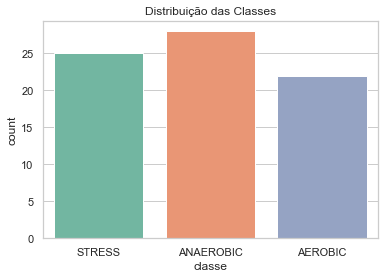


🚨 Valores ausentes por coluna:


Id                 0
classe             0
acc_energy         0
acc_entropy        0
acc_mag_mean       0
acc_mag_std        0
bvp_mean           0
eda_mean           0
eda_phasic_mean    0
eda_std            0
eda_tonic_mean     0
hr_mean            0
hr_std             0
hrv_rmssd          2
hrv_sdnn           2
temp_mean          0
temp_slope         0
temp_std           0
dtype: int64

In [3]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Medidas descritivas
# ==========================================================
medidas_descritivas(df)


--- Boxplots e Histogramas ---


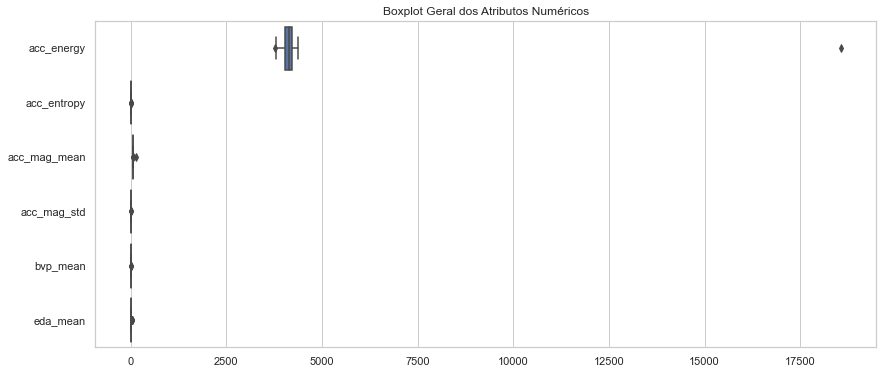

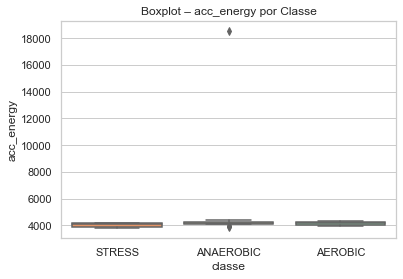

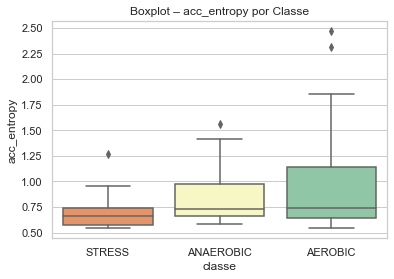

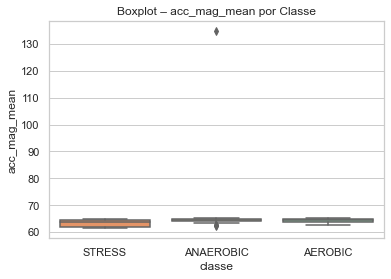

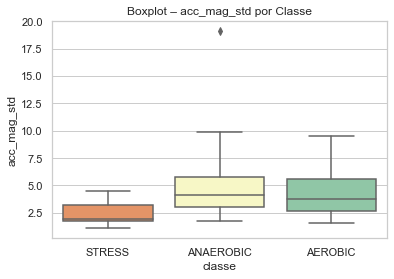

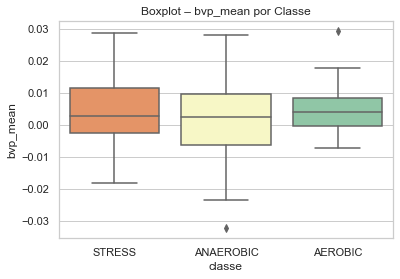

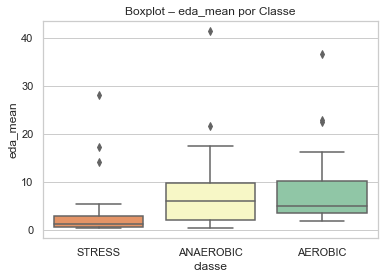

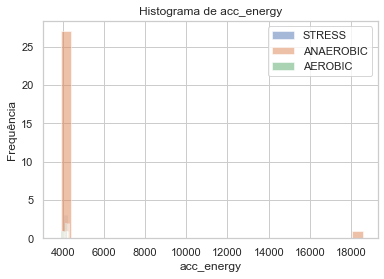

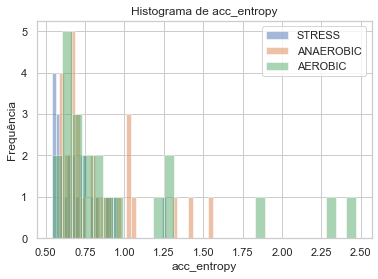

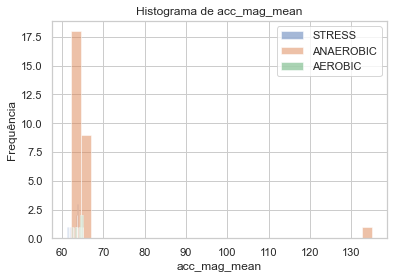

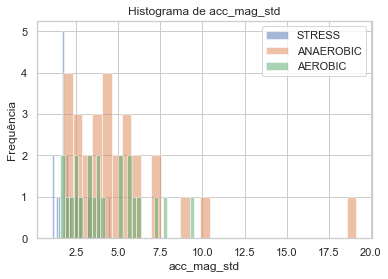

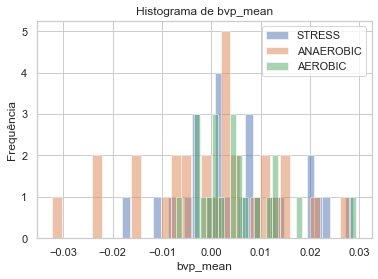

In [4]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Boxplots e Histogramas
# ==========================================================
from scripts.analise_exploratoria import boxplots_e_histogramas
boxplots_e_histogramas(df)


--- Matriz de Correlação ---


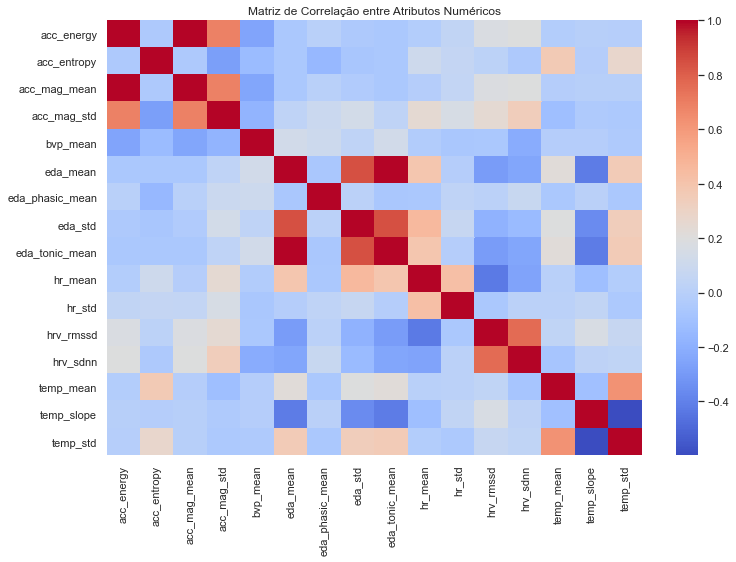


🔗 Maiores correlações:


eda_mean      eda_tonic_mean    1.000000
acc_energy    acc_mag_mean      0.999056
eda_mean      eda_std           0.849207
eda_std       eda_tonic_mean    0.849195
hrv_rmssd     hrv_sdnn          0.769044
acc_mag_mean  acc_mag_std       0.692277
acc_energy    acc_mag_std       0.690494
temp_mean     temp_std          0.631260
temp_slope    temp_std         -0.597929
eda_std       hr_mean           0.461318
dtype: float64

In [5]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Correlação entre atributos
# ==========================================================
correlacao_atributos(df)



--- Pairplot Amostrado ---
Gerando pairplot com 75 amostras e 5 atributos...


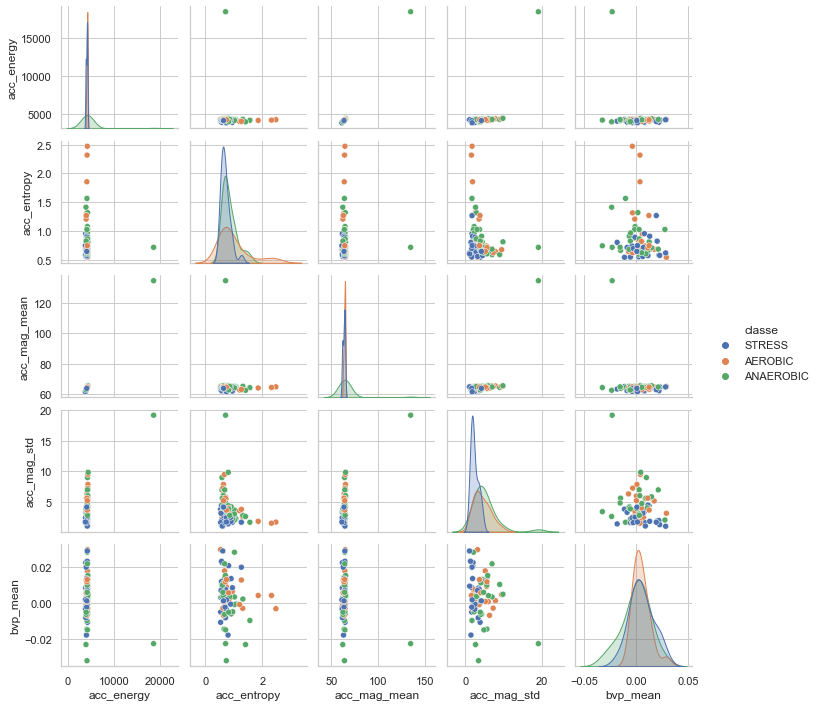

In [6]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Pairplot amostrado
# ==========================================================
pairplot_amostrado(df)


Foram plotadas as séries agregadas de cada sensor (HR, HRV, EDA, ACC e temperatura) ao longo das amostras. Esses gráficos permitem identificar padrões globais entre os participantes, como variações amplas na atividade eletrodérmica e na frequência cardíaca, frequentemente associadas a estados de estresse, bem como valores mais elevados de aceleração média em casos de exercícios aeróbicos e anaeróbicos.

TEXTO DE INTERPRETACAO DOS GRAFICOS MAIS IMPORTANTES 
(exemplo: Os gráficos temporais permitiram observar tendências gerais nos sinais fisiológicos. Picos repentinos em HR e ACC indicam episódios de esforço físico, enquanto aumentos abruptos em EDA refletem respostas de estresse agudo. Já quedas graduais em temperatura são consistentes com a literatura sobre vasoconstrição induzida por estresse. A variabilidade entre amostras também revelou perfis distintos de ativação fisiológica entre os participantes.)
(como analisar abaixo)


⭐ 1) Como interpretar gráficos temporais (plot_series_temporais)

Um gráfico temporal no seu caso não é o tempo real da coleta, mas o conjunto de amostras ordenadas (usuários). Mesmo assim, ele revela padrões fisiológicos úteis.

✔ O que observar e como interpretar
1. Picos (valores muito altos repentinamente)
📌 Em HR (Frequência Cardíaca):

Picos altos → esforço físico intenso ou resposta de estresse.

Se associados a baixo ACC → mais estresse do que exercício.

📌 Em EDA (Condutância da pele):

Picos de EDA são o melhor indicador de estresse.

Estão associados a sudorese simpática.

📌 Em ACC:

Picos indicam movimentos bruscos, como corrida ou exercícios anaeróbicos.

2. Quedas bruscas (valores que despencam)
📌 Em TEMP:

Quedas suaves podem indicar estresse (vasoconstrição periférica).

Quedas rápidas podem indicar sensor soltando (ruído).

📌 Em HR:

Quedas grandes podem significar término de exercício.

3. Tendências (crescimento ou queda gradual)
📌 HR subindo gradualmente:

Indica ativação do sistema cardiovascular, geralmente exercício prolongado.

📌 EDA subindo ao longo do gráfico:

Indica acúmulo de ativação mental → estresse sustentado.

📌 TEMP caindo lentamente:

Sinal clássico em estudos de estresse.

4. Variação (sinal “instável”, oscilando muito)
📌 HRV baixa (RMSSD baixo) + alta variabilidade de HR

→ organismo em estado de alerta / estresse.

📌 ACC variando muito:

→ exercícios intermitentes.

📌 EDA “tremido”:

→ possível ruído ou muita excitação simpática.

5. Flat lines (valores constantes demais)

Isso normalmente indica sensor com problema, exceto:

HRV pode ser naturalmente baixo em certas pessoas.

TEMP pode ser estável em repouso.


--- Séries Temporais ---


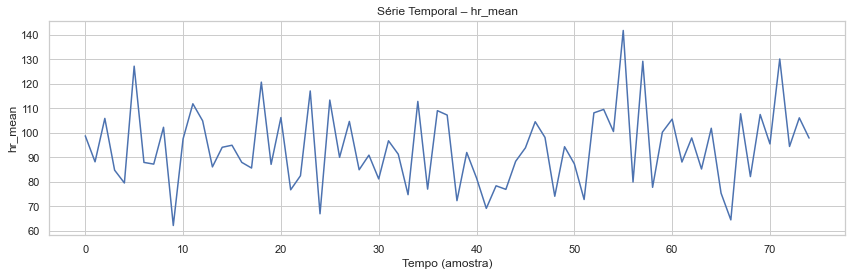

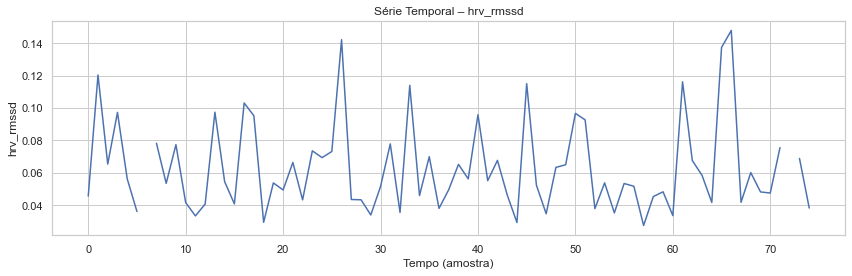

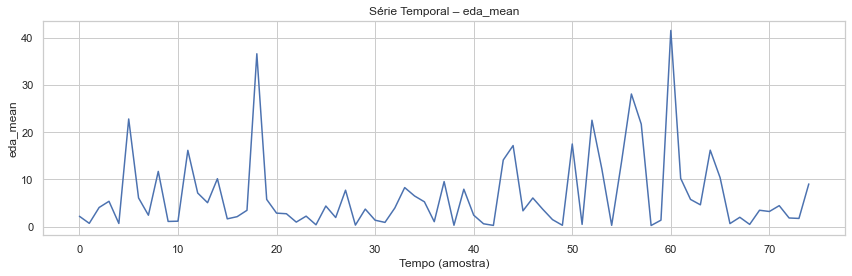

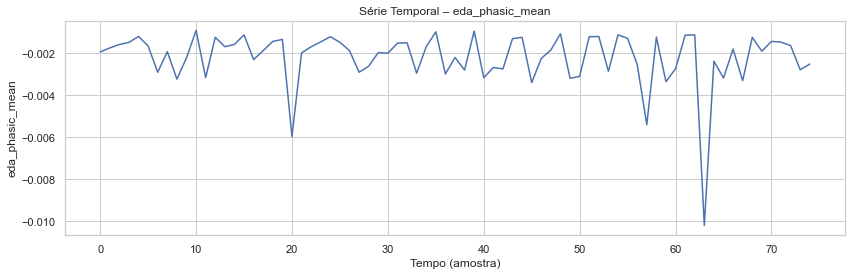

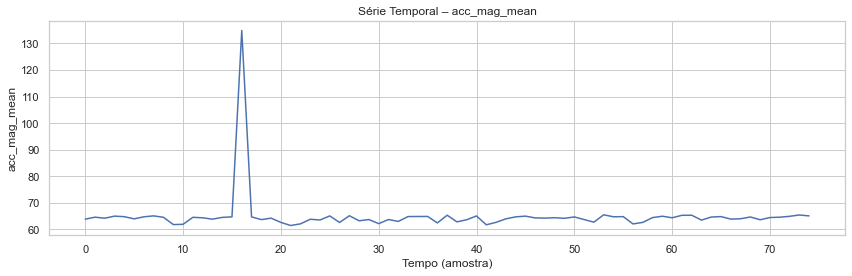

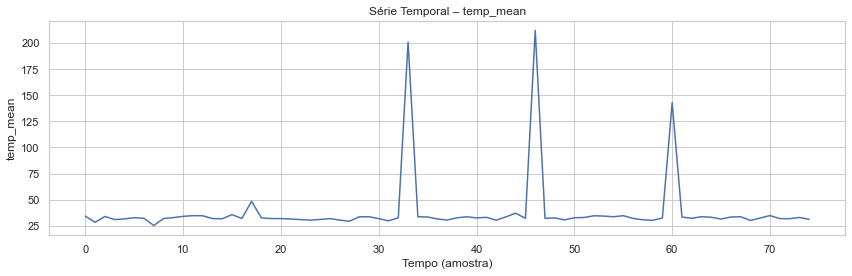

In [7]:
plot_series_temporais(df, [
    "hr_mean",
    "hrv_rmssd",
    "eda_mean",
    "eda_phasic_mean",
    "acc_mag_mean",
    "temp_mean"
])


Também foram analisadas relações entre pares de sensores, como HR × EDA, ACC × HR e HRV × EDA. Os gráficos de dispersão revelam separações naturais entre os estados fisiológicos: indivíduos em condição de estresse tendem a apresentar EDA elevada combinada com RMSSD reduzido, enquanto atividades aeróbicas e anaeróbicas apresentam maior magnitude de aceleração e frequência cardíaca, porém com diferentes assinaturas eletrodérmicas.

TEXTO COM INTERPRETACAO DOS GRAFICOS!!! (exemplo: Os gráficos de dispersão mostraram relações importantes entre sensores. O par HR × EDA evidenciou um agrupamento de indivíduos com ambos os valores elevados, sugerindo estados de alto arousal fisiológico, típicos de estresse. A relação inversa entre HRV e EDA phasic indica diminuição da atividade parassimpática em situações de estresse. Já ACC × HR ajudou a diferenciar claramente atividades físicas de episódios de estresse, já que esforço físico tende a aumentar simultaneamente aceleração e frequência cardíaca.)

⭐ 2) Como interpretar scatter plots (scatter_duplo)

Scatter plots são ainda mais importantes, porque mostram relações entre variáveis.

✔ O que procurar:
1. Clusters (agrupamentos visíveis)
✔ Se HR_mean × EDA_mean gera três nuvens separadas:

Cluster HR alto + EDA alto → STRESS

Cluster HR alto + ACC alto → EXERCISE (AEROBIC/ANAEROBIC)

Cluster HR baixo + EDA baixo → repouso / baseline

Esse é o gráfico mais poderoso da análise.

2. Correlação (linha inclinada)
📌 HR_mean vs EDA_mean com inclinação positiva

Quanto maior a ativação simpática, maior HR e EDA.

Indica arousal fisiológico.

📌 HRV vs EDA_phasic com inclinação negativa

Quanto maior o estresse:

HRV ↓

EDA ↑

Esse padrão é amplamente comprovado em neurofisiologia.

3. Pontos muito distantes do resto (outliers)

Usado para:

identificar erros de sensor

indivíduos muito diferentes (podem distorcer o modelo)

4. Faixas vazias (sem pontos)

Se no scatter HR × ACC aparecerem faixas vazias:

você tem faixas de movimento inexistentes, indicando que certas atividades não ocorreram.

5. Distribuição desigual dos pontos
📌 Pontos concentrados em uma região:

o dataset é desbalanceado naquela variável

ajuda a entender por que alguns modelos têm dificuldade

6. Curvaturas (relação não linear)

Exemplo:

Se ACC aumenta, HR aumenta até um limite, e depois estabiliza:

→ relação não linear → SVM RBF ou Random Forest podem capturar melhor que Regressão Logística.

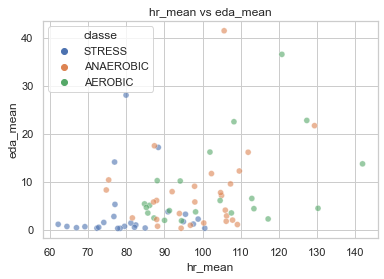

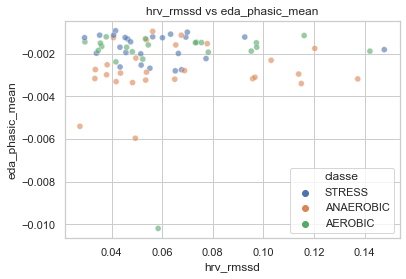

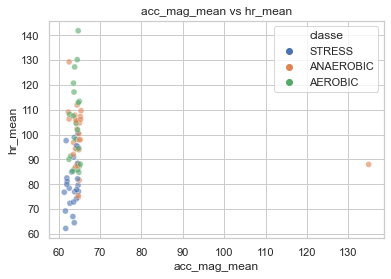

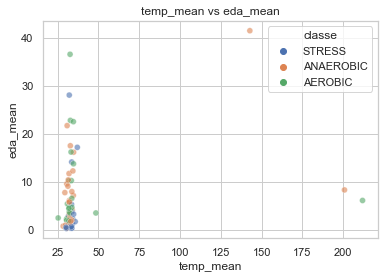

In [8]:
scatter_duplo(df, "hr_mean", "eda_mean")
scatter_duplo(df, "hrv_rmssd", "eda_phasic_mean")
scatter_duplo(df, "acc_mag_mean", "hr_mean")
scatter_duplo(df, "temp_mean", "eda_mean")


---
### Pré-processamento

Nesta seção, as funções da etapa de pré-processamento dos dados devem ser implementadas e aplicadas (se necessário).

In [9]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Tratamento de faltantes e outliers
# ==========================================================

#  nao ta precisando pq nn tem valor ausente
# df_limpo = tratar_valores_ausentes(df)


# # ⭐ POR QUE IQR NÃO FUNCIONA PARA SINAIS FISIOLÓGICOS?
# Porque IQR assume distribuição simétrica e estável, o que não ocorre:
# EDA → altamente assimétrico
# HRV → distribuição longa
# ACC → altamente dependente de atividade
# TEMP → muito estável, punindo levemente qualquer variação
# BVP → ruído natural que parece outlier
# ➡️ IQR gera muitos falsos positivos.
# ➡️ E a regra .any(axis=1) remove a linha inteira se 1 atributo for outlier.

df_limpo = limitar_outliers_zscore(df, zmax=3.0)

df_limpo.head()

,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,4068.866638,0.820908,63.758315,1.934911,0.020494,2.189811,-0.001937,0.514308,2.191749,98.821344,12.900442,0.045673,0.064240,34.270396,0.000272,0.650409
1,U_56491,ANAEROBIC,4208.309169,0.682113,64.493546,6.992256,0.021553,0.695010,-0.001748,0.666640,0.696758,88.201980,19.964373,0.120337,0.207697,28.349428,-0.000181,0.684502
2,U_94628,ANAEROBIC,4142.529156,0.599849,64.116317,5.623789,0.009702,4.049409,-0.001584,3.069452,4.050993,105.932371,19.995435,0.065383,0.105671,33.942008,0.000139,0.573410
3,U_97819,AEROBIC,4220.643865,0.540780,64.888648,3.179186,0.029392,5.359092,-0.001485,5.371593,5.360577,84.796326,11.185594,0.097257,0.114572,30.956354,0.000148,0.788914
4,U_96956,STRESS,4188.899763,0.666053,64.686163,2.144774,0.001560,0.670497,-0.001202,0.493036,0.671699,79.560809,6.384096,0.056268,0.073907,31.656112,-0.000073,0.434737


In [10]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Carregar os dados de teste e tratar igual ao treino
# ==========================================================
df_test = gerar_dataset(base_path, mode="test")
df_test = tratar_valores_ausentes(df_test)

In [11]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Preparar dados para os modelos
# ==========================================================
X_base, y_base, X_test, test_ids, label_encoder, scaler = preparar_dados(
    df_limpo,
    df_test
)

X_base.shape, X_test.shape

((75, 16), (25, 16))

In [12]:
from sklearn.model_selection import train_test_split

# dividir treino em treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X_base, y_base, 
    test_size=0.2,
    random_state=42,
    stratify=y_base
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((60, 16), (15, 16), (60,), (15,))

---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

Treinamos os seguintes modelos:
- KNN  
- Naive Bayes  
- Regressão Logística  
- Rede Neural (MLP)  
- SVM  


In [13]:
# ==========================================================
# EXPERIMENTOS - Treinamento de modelos baseline
# ==========================================================
model_knn = treinar_knn(X_train, y_train)
model_nb = treinar_naive_bayes(X_train, y_train)
model_lr = treinar_regressao_logistica(X_train, y_train)
model_mlp = treinar_rede_neural(X_train, y_train)
model_svm = treinar_svm(X_train, y_train)

modelos_baseline = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP (Simples)": model_mlp,
    "SVM (Simples)": model_svm
}

modelos_baseline


--- Treinando KNN (k=7) ---

--- Treinando Naive Bayes (Gaussian) ---

--- Treinando Regressão Logística ---

--- Treinando Rede Neural (MLP) ---

--- Treinando SVM (RBF) ---


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'Naive Bayes': GaussianNB(),
 'Regressão Logística': LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
 'MLP (Simples)': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
 'SVM (Simples)': SVC(probability=True, random_state=42)}

In [14]:
# ==========================================================
# EXPERIMENTOS - Validação cruzada (baseline)
# ==========================================================

print("=== Validação Cruzada (5-fold) - Baselines ===\n")

for nome, modelo in modelos_baseline.items():
    print(f"\nModelo: {nome}")
    avaliar_com_crossval(modelo, X_train, y_train, cv=5)


=== Validação Cruzada (5-fold) - Baselines ===


Modelo: KNN

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.33333333 0.58333333 0.66666667 0.75      ]
Média: 0.5666666666666667
Desvio: 0.14337208778404378

Modelo: Naive Bayes

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.33333333 0.41666667 0.41666667 0.58333333 0.58333333]
Média: 0.4666666666666667
Desvio: 0.10000000000000002

Modelo: Regressão Logística

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.5        0.58333333 0.75       0.75      ]
Média: 0.6166666666666667
Desvio: 0.1130388330520878

Modelo: MLP (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.5        0.58333333 0.91666667 0.91666667]
Média: 0.6833333333333333
Desvio: 0.19293061504650375

Modelo: SVM (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.5        0.75       0.66666667 0.83333333

In [15]:
# ==========================================================
# EXPERIMENTOS - SVM Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando SVM Otimizado ===")
model_svm_best = treinar_svm_otimizado(X_train, y_train)
model_svm_best



=== Treinando SVM Otimizado ===

=== Ajustando SVM com GridSearchCV ===
Melhores parâmetros: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Melhor score médio CV: 0.7333333333333334


SVC(C=10, gamma=0.01, probability=True, random_state=42)

In [16]:
# ==========================================================
# EXPERIMENTOS - MLP Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando MLP Otimizado ===")
model_mlp_best = treinar_mlp_otimizado(X_train, y_train)
model_mlp_best



=== Treinando MLP Otimizado ===

=== Ajustando MLP com GridSearchCV ===
Melhores parâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}
Melhor score CV: 0.7


MLPClassifier(hidden_layer_sizes=(64, 32), learning_rate_init=0.01,
              max_iter=600, random_state=42)

In [17]:
# ==========================================================
# EXPERIMENTOS - Validação cruzada (modelos otimizados)
# ==========================================================

print("=== Validação Cruzada - Modelos Otimizados ===\n")

print("\nSVM Otimizado:")
avaliar_com_crossval(model_svm_best, X_train, y_train)

print("\nMLP Otimizado:")
avaliar_com_crossval(model_mlp_best, X_train, y_train)


=== Validação Cruzada - Modelos Otimizados ===


SVM Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.66666667 0.66666667 0.83333333 0.83333333]
Média: 0.7333333333333334
Desvio: 0.08164965809277264

MLP Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.5        0.66666667 0.91666667 0.91666667]
Média: 0.7
Desvio: 0.18708286933869703


array([0.5       , 0.5       , 0.66666667, 0.91666667, 0.91666667])

In [23]:
# ==========================================================
# EXPERIMENTOS - Comparação geral (baseline + otimizados)
# ==========================================================

modelos = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP Simples": model_mlp,
    "SVM Simples": model_svm,
    "MLP Otimizado": model_mlp_best,
    "SVM Otimizado": model_svm_best
}

resultados = {}

for nome, modelo in modelos.items():
    print(f"\nModelo: {nome}")
    scores = avaliar_com_crossval(modelo, X_train, y_train)
    resultados[nome] = scores.mean()

print("\n\n=== Médias de Acurácia ===")
resultados



Modelo: KNN

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.33333333 0.58333333 0.66666667 0.75      ]
Média: 0.5666666666666667
Desvio: 0.14337208778404378

Modelo: Naive Bayes

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.33333333 0.41666667 0.41666667 0.58333333 0.58333333]
Média: 0.4666666666666667
Desvio: 0.10000000000000002

Modelo: Regressão Logística

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.5        0.58333333 0.75       0.75      ]
Média: 0.6166666666666667
Desvio: 0.1130388330520878

Modelo: MLP Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.5        0.58333333 0.91666667 0.91666667]
Média: 0.6833333333333333
Desvio: 0.19293061504650375

Modelo: SVM Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.5        0.5        0.75       0.66666667 0.83333333]
Média: 0.65
Desvio: 0.13333333333333336

Modelo: M

{'KNN': 0.5666666666666667,
 'Naive Bayes': 0.4666666666666667,
 'Regressão Logística': 0.6166666666666667,
 'MLP Simples': 0.6833333333333333,
 'SVM Simples': 0.65,
 'MLP Otimizado': 0.7,
 'SVM Otimizado': 0.7333333333333334}

---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

Para comparamos o desempenho dos modelos usamos:
- Métricas macro  
- Matriz de confusão  
- Curvas de aprendizado  
- Teste de McNemar para significância estatística  


In [24]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Avaliação agregada
# ==========================================================
df_metrics = avaliar_modelos_dict(modelos, X_train, y_train)
df_metrics

,accuracy,precision_macro,recall_macro,f1_macro
modelo,,,,
KNN,0.683333,0.663723,0.668687,0.660325
Naive Bayes,0.600000,0.705163,0.614646,0.562168
Regressão Logística,0.850000,0.853333,0.843434,0.845261
MLP Simples,1.000000,1.000000,1.000000,1.000000
SVM Simples,0.883333,0.888889,0.877104,0.879648
MLP Otimizado,1.000000,1.000000,1.000000,1.000000
SVM Otimizado,0.883333,0.883205,0.880471,0.881481


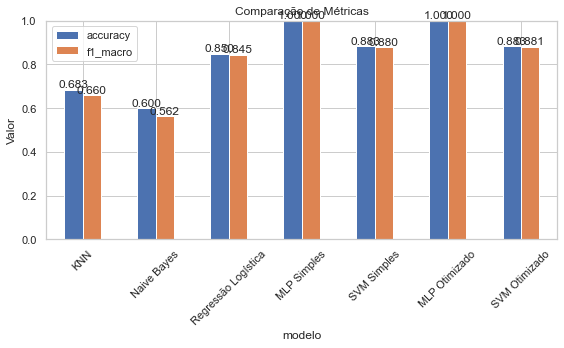

In [25]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Gráfico de barras das métricas principais
# ==========================================================
plot_metric_bars(df_metrics, metrics=("accuracy", "f1_macro"))

In [26]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Classification Reports completos
# ==========================================================
mostrar_classification_reports(modelos, X_val, y_val)


=== Classification Report: KNN ===
              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
           1       0.50      0.50      0.50         6
           2       0.80      0.80      0.80         5

    accuracy                           0.53        15
   macro avg       0.52      0.52      0.52        15
weighted avg       0.53      0.53      0.53        15


=== Classification Report: Naive Bayes ===
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.40      0.33      0.36         6
           2       0.57      0.80      0.67         5

    accuracy                           0.47        15
   macro avg       0.43      0.46      0.44        15
weighted avg       0.44      0.47      0.44        15


=== Classification Report: Regressão Logística ===
              precision    recall  f1-score   support

           0       0.33      0.50      0.40        

In [27]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Tabela detalhada por classe (para o melhor modelo)
# ==========================================================
modelo_principal = modelos["SVM Otimizado"]  
tabela_por_classe(modelo_principal, X_val, y_val)


,precision,recall,f1,support
0,0.428571,0.750000,0.545455,4
1,1.000000,0.333333,0.500000,6
2,0.833333,1.000000,0.909091,5


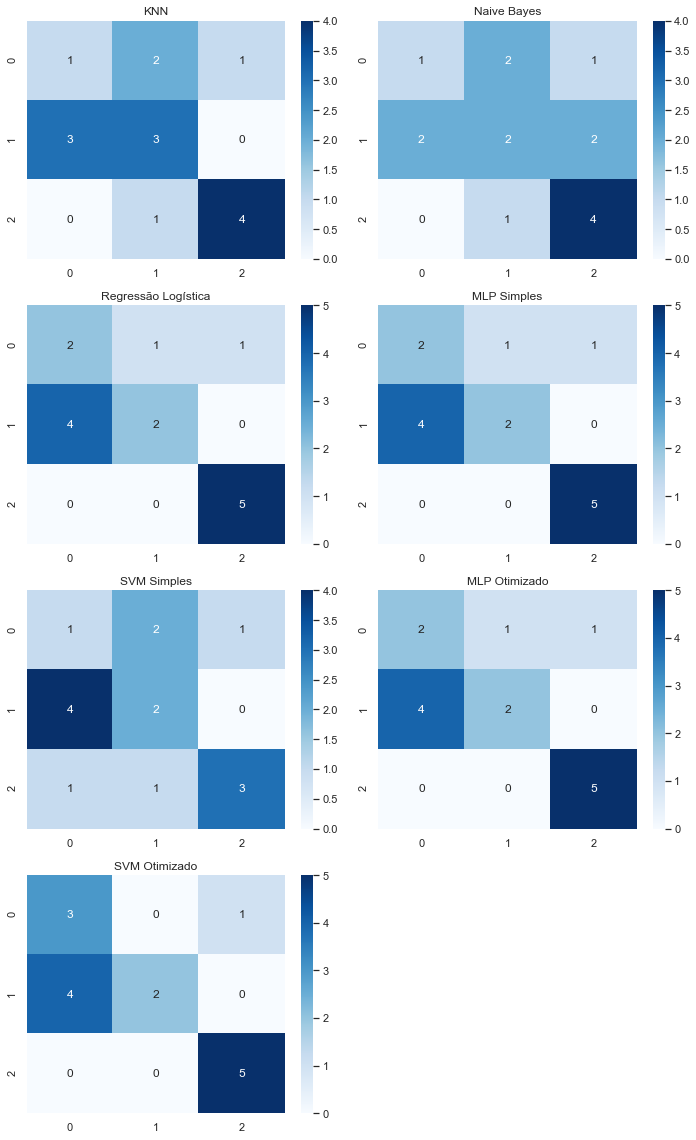

In [28]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Matrizes de confusão de todos os modelos
# ==========================================================
comparar_modelos_plot_confusao(
    modelos,
    X_val,
    y_val,
    labels=sorted(set(y_val)),
    normalize=False,
    max_per_row=2
)


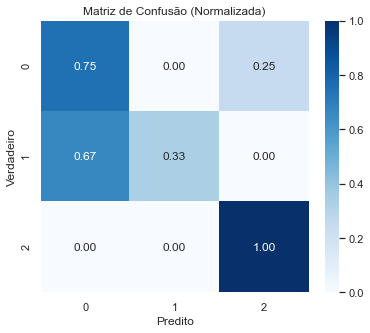

In [29]:
# =========================
# ANÁLISE DOS RESULTADOS - Matriz de confusão normalizada do melhor modelo
# =========================
plot_confusion_matrix_model(
    modelo_principal,
    X_val, y_val,
    labels=sorted(set(y_val)),
    normalize=True
)


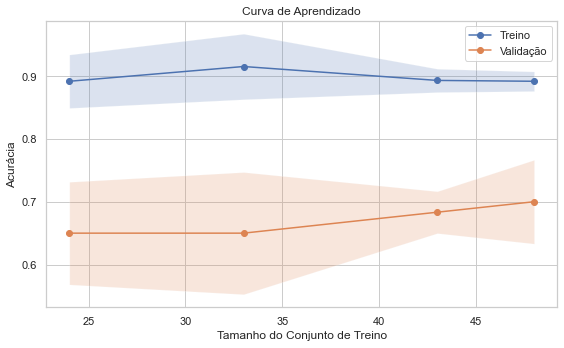

In [ ]:
# =========================
# ANÁLISE DOS RESULTADOS - Curva de aprendizado para o melhor modelo
# =========================
from sklearn.model_selection import StratifiedKFold

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve_model(
    modelo_principal, 
    X_train, y_train,
    cv=cv5,
    train_sizes=[0.5, 0.7, 0.9, 1.0]
)


In [32]:
# =========================
# ANÁLISE DOS RESULTADOS - Teste de McNemar (entre dois modelos)
# =========================
modelo_a = modelos["SVM Otimizado"]
modelo_b = modelos["MLP Otimizado"]

pvalor = teste_mcnemar(modelo_a, modelo_b, X_val, y_val)
print("p-valor McNemar:", pvalor)

if pvalor < 0.05:
    print("Diferença estatisticamente significativa!")
else:
    print("Não há diferença estatisticamente significativa.")

p-valor McNemar: 1.0
Não há diferença estatisticamente significativa.


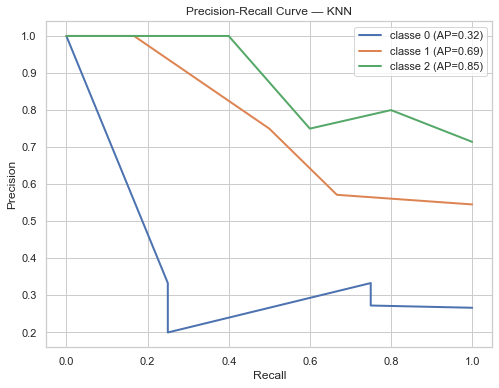

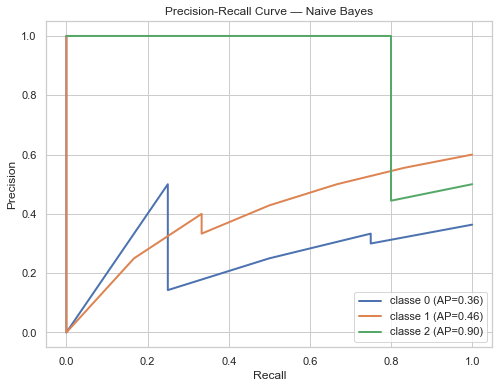

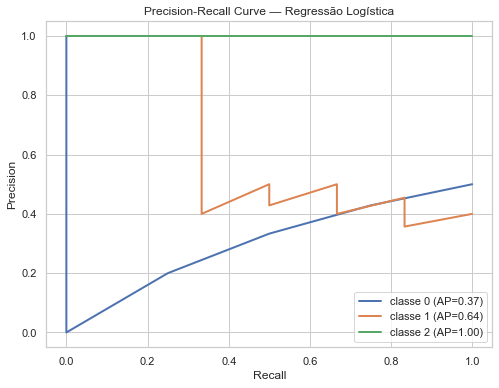

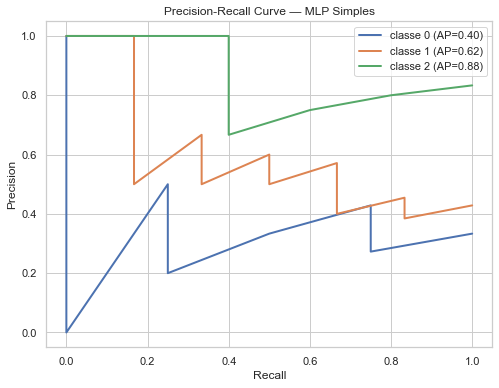

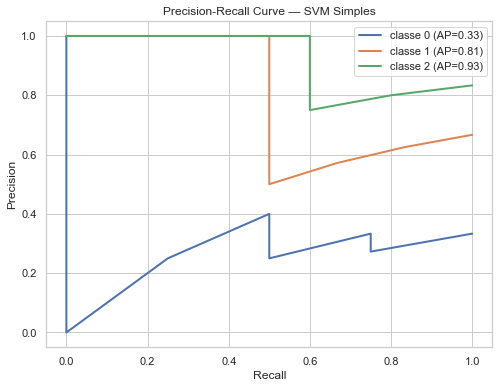

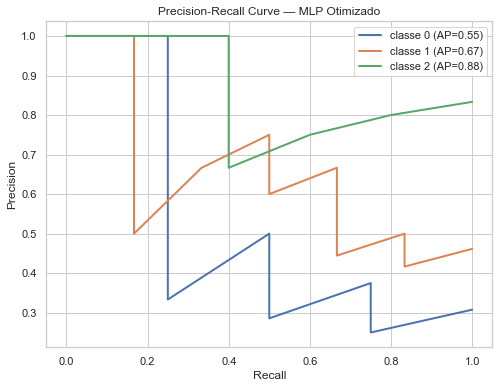

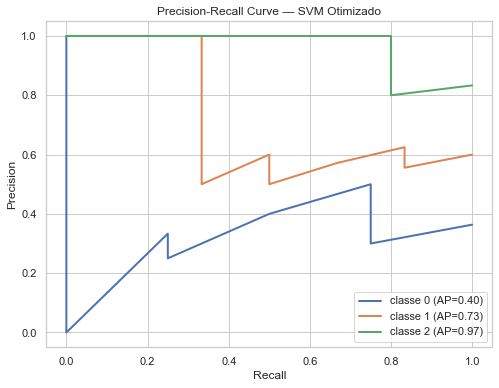

In [33]:
# =========================
# ANÁLISE DOS RESULTADOS - Curvas Precision–Recall multiclass (um gráfico por modelo)
# =========================
plot_precision_recall_multiclass(modelos, X_val, y_val)

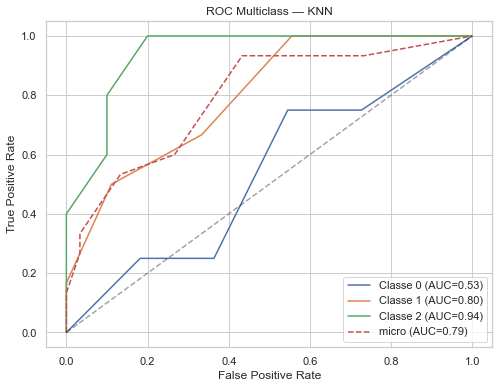

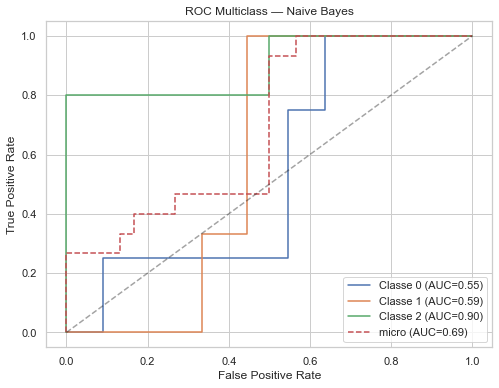

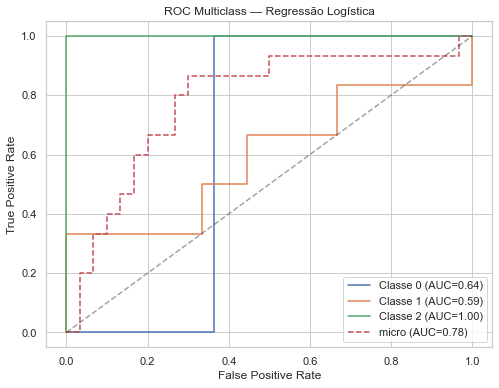

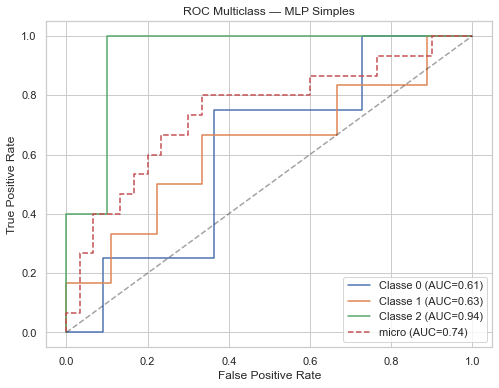

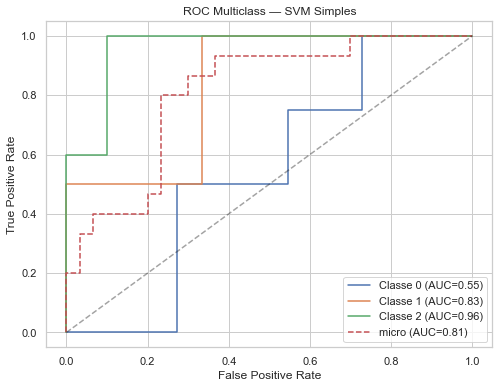

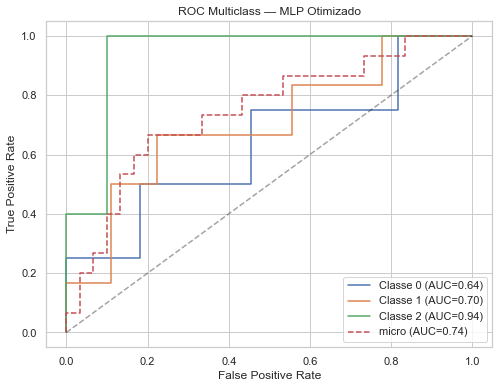

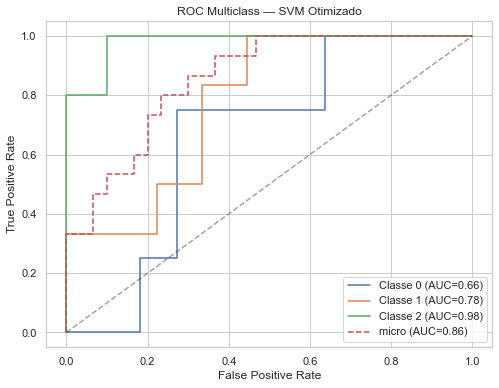

In [34]:
# =========================
# ANÁLISE DOS RESULTADOS - Curvas ROC multiclass
# =========================
plot_roc_multiclass(modelos, X_val, y_val)

In [35]:
# =========================
# ANÁLISE DOS RESULTADOS - Importância de features (para o melhor modelo)
# =========================

# nomes das colunas usadas no treinamento
feature_names = list(X_train.columns)

df_imp = importancia_features_modelo(
    modelo_principal,
    X_val,
    y_val,
    feature_names=feature_names,
    top_k=20
)

df_imp


,feature,importance
0,hr_mean,0.196667
1,eda_phasic_mean,0.136667
2,eda_std,0.096667
3,acc_mag_std,0.053333
4,eda_mean,0.023333
5,eda_tonic_mean,0.023333
6,acc_entropy,0.020000
7,acc_energy,0.000000
8,acc_mag_mean,0.000000
9,temp_mean,0.000000


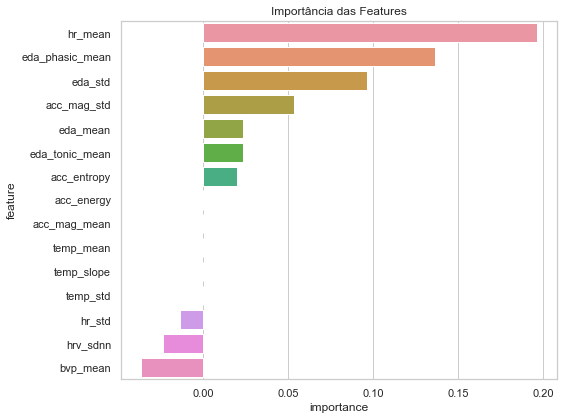

In [36]:
# =========================
# ANÁLISE DOS RESULTADOS - Gráfico de importância das features
# =========================
plot_importancia(df_imp, top_k=15)


In [37]:
# =========================
# ANÁLISE DOS RESULTADOS - Análise de erros por classe
# =========================
erro_df = analise_erros_por_classe(
    modelo_principal,
    X_val,
    y_val,
    feature_df=pd.DataFrame(X_val, columns=feature_names),
    labels=sorted(set(y_val))
)

erro_df


,classe,FN_count,FP_count,TP_count,FN_percent,FP_percent,FN_feature_mean,FP_feature_mean
0,0,1,4,3,0.066667,0.266667,"{'acc_energy': -0.3354211538053306, 'acc_entro...","{'acc_energy': 0.016839307471200854, 'acc_entr..."
1,1,4,0,2,0.266667,0.000000,"{'acc_energy': 0.016839307471200854, 'acc_entr...",{}
2,2,0,1,5,0.000000,0.066667,{},"{'acc_energy': -0.3354211538053306, 'acc_entro..."


In [42]:
gerar_submissao(
    modelo_principal,
    X_test,
    test_ids,
    label_encoder,
    nome_arquivo="submission.csv"
)


--- Gerando arquivo de submissão ---

✅ Submissão salva em: dataset/submission.csv

Prévia:
        Id Predicted_0 Predicted_1 Predicted_2
0  U_19341  0.00823952     0.01026    0.981501
1  U_54670    0.286055    0.240076    0.473869
2  U_21920   0.0481739   0.0949014    0.856925
3  U_58128    0.437675    0.404677    0.157648
4  U_73365     0.40374    0.538435    0.057825


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.00823952,0.01026,0.981501
1,U_54670,0.286055,0.240076,0.473869
2,U_21920,0.0481739,0.0949014,0.856925
3,U_58128,0.437675,0.404677,0.157648
4,U_73365,0.40374,0.538435,0.057825
5,U_89682,0.241971,0.691592,0.0664373
6,U_11501,0.0687395,0.0587254,0.872535
7,U_46423,0.0453097,0.0285483,0.926142
8,U_71408,0.0155425,0.0113841,0.973073
9,U_95655,0.455927,0.315989,0.228085
